## 0. Setup

### 0.1 Install PySpark

In [ ]:
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark==3.2.1

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://security.debian.org/debian-security buster/updates InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease




openjdk-11-jdk is already the newest version (11.0.14+9-1~deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession
            .builder
            .config(
                "spark.jars",
                "jars/singlestore-jdbc-client-1.0.1.jar, \
                jars/singlestore-spark-connector_2.12-4.0.0-spark-3.2.0.jar, \
                jars/spray-json_3-1.3.6.jar"
            )
            .getOrCreate()
        )

In [ ]:
spark.version

'3.2.1'

### 0.2 Connect to SingleStore DB

In [ ]:
server = "<TO DO>"
password = "<TO DO>"
 
port = "3306"
cluster = server + ":" + port

In [ ]:
spark.conf.set("spark.datasource.singlestore.ddlEndpoint", cluster)
spark.conf.set("spark.datasource.singlestore.user", "admin")
spark.conf.set("spark.datasource.singlestore.password", password)
spark.conf.set("spark.datasource.singlestore.disablePushdown", "false")

## 1. Apache Spark

### 1.1 Create Spark Dataframe

In [ ]:
iris_df = spark.read.csv(
                    "data/iris.csv",
                    header = True,
                    inferSchema = True
                )

In [ ]:
iris_df.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



### 1.2 Exploratory Data Analysis (EDA)

In [ ]:
(iris_df
    .groupBy("species")
    .count()
    .show()
)

+---------------+-----+
|        species|count|
+---------------+-----+
| Iris-virginica|   50|
|    Iris-setosa|   50|
|Iris-versicolor|   50|
+---------------+-----+



In [ ]:
(iris_df
    .describe(
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width"
    )
    .show()
)

+-------+------------------+-------------------+------------------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|
+-------+------------------+-------------------+------------------+------------------+
|  count|               150|                150|               150|               150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|
|    min|               4.3|                2.0|               1.0|               0.1|
|    max|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+-------------------+------------------+------------------+



In [ ]:
# https://plotly.com/python/pca-visualization/

import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd

pandas_iris_df = iris_df.toPandas()

X = pandas_iris_df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]

pca = PCA(n_components = 2)
components = pca.fit_transform(X)

pca_fig = px.scatter(
    components,
    x = 0,
    y = 1,
    color = pandas_iris_df["species"]
)

pca_fig.show()

[]

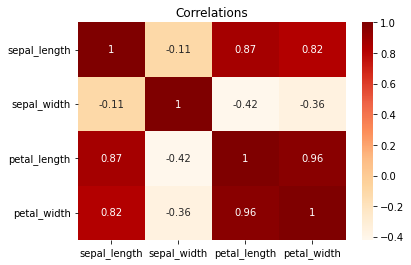

In [ ]:
# More about correlations:
# https://www.w3schools.com/python/pandas/pandas_correlations.asp

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(
    pandas_iris_df.corr(),
    cmap = "OrRd",
    annot = True
)

plt.title("Correlations")
plt.plot()

### 1.3 Write Spark Dataframe to SingleStore DB

In [ ]:
(iris_df.write
    .format("singlestore")
    .option("loadDataCompression", "LZ4")
    .mode("overwrite")
    .save("iris_db.iris")
)

## 2. MindsDB

### 2.1 Create Spark Dataframe

In [ ]:
from pyspark.sql.types import *

btc_schema = StructType([
    StructField("ds", DateType(), True),
    StructField("y", FloatType(), True)
])

In [ ]:
btc_df = spark.read.csv(
                    "data/btc_data.csv",
                    header = True,
                    dateFormat = "YYYY-MM-DD",
                    schema = btc_schema
                )

In [ ]:
btc_df.show(5)

+----------+---------+
|        ds|        y|
+----------+---------+
|2011-12-31| 4.471603|
|2012-01-01|     4.71|
|2012-01-02|      5.0|
|2012-01-03|   5.2525|
|2012-01-04|5.2081594|
+----------+---------+
only showing top 5 rows



### 2.2 Write Spark Dataframe to SingleStore DB

In [ ]:
(btc_df.write
    .format("singlestore")
    .option("loadDataCompression", "LZ4")
    .mode("overwrite")
    .save("btc_db.btc")
)

### 2.3 Create MindsDB Datasource

In [ ]:


df_1 = _deepnote_execute_sql("""DROP DATASOURCE btc_data;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_1

In [ ]:


df_2 = _deepnote_execute_sql("""CREATE DATASOURCE btc_data
WITH ENGINE = "singlestore",
    PARAMETERS = {
        "user" : "admin",
        "password" : "<TO DO>",
        "host" : "<TO DO>",
        "port" : 3306,
        "database" : "btc_db"
    }
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_2

In [ ]:


df_3 = _deepnote_execute_sql("""SELECT *
FROM btc_data.btc
ORDER BY ds
LIMIT 5;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_3

,ds,y
0,2011-12-31,4.4716
1,2012-01-01,4.71
2,2012-01-02,5.0
3,2012-01-03,5.2525
4,2012-01-04,5.20816


### 2.4 Create MindsDB Predictor

In [ ]:


df_4 = _deepnote_execute_sql("""DROP PREDICTOR mindsdb.btc_pred;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_4

In [ ]:


df_5 = _deepnote_execute_sql("""CREATE PREDICTOR btc_pred
FROM btc_data
    (SELECT * FROM btc)
PREDICT y
ORDER BY ds
WINDOW 1;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_5

In [ ]:


df_6 = _deepnote_execute_sql("""SHOW PREDICTORS;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_6

,name,status,accuracy,predict,update_status,mindsdb_version,error,select_data_query,training_options
0,btc_pred,complete,0.45486975274253294,y,up_to_date,22.4.5.0,None,,
1,iris_model_v1,complete,0.9333333333333332,species,up_to_date,22.3.5.0,None,,


In [ ]:


df_7 = _deepnote_execute_sql("""DESCRIBE btc_pred;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_7

,accuracies,column_importances,outputs,inputs,datasource,model
0,{'evaluate_num_array_accuracy': 0.454869752742...,{},['y'],"['ds', '__mdb_ts_previous_y']",btc_pred_31,encoders --> dtype_dict --> dependency_dict --...


In [ ]:


df_8 = _deepnote_execute_sql("""DESCRIBE btc_pred.features;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_8

,column,type,encoder,role
0,ds,date,ArrayEncoder,feature
1,y,float,TsNumericEncoder,target


### 2.5 Show MindsDB Predictions

In [ ]:


pred_10_df = _deepnote_execute_sql("""SELECT orig_table.ds AS date, pred_table.y AS predicted_y, orig_table.y AS actual_y
FROM btc_data.btc AS orig_table
JOIN mindsdb.btc_pred AS pred_table
WHERE orig_table.ds > '2011-12-30'
LIMIT 10;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
pred_10_df

,date,predicted_y,actual_y
0,2020-09-14,10388.046619,10314.3
1,2020-09-13,10337.436201,10409.8
2,2020-09-12,10298.611981,10363.9
3,2020-09-11,10275.237536,10299.2
4,2020-09-10,10157.706201,10329.1
5,2020-09-09,10163.480530,10161.5
6,2020-09-08,10156.737704,10175.6
7,2020-09-07,10209.844515,10159.2
8,2020-09-06,10335.935433,10178.4
9,2020-09-05,10588.904678,10324.6


In [ ]:
line_fig = px.line(
                pred_10_df,
                x = "date",
                y = ["actual_y", "predicted_y"]
            )

line_fig.show()

In [ ]:


df_10 = _deepnote_execute_sql("""SELECT orig_table.ds AS date, pred_table.y AS predicted_y, orig_table.y AS actual_y
FROM btc_data.btc AS orig_table
JOIN mindsdb.btc_pred AS pred_table
WHERE orig_table.ds > LATEST;
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
df_10

,date,predicted_y,actual_y
0,2020-09-14,NaN,10314.3
1,None,7537.247702,NaN


In [ ]:


pred_all_df = _deepnote_execute_sql("""SELECT orig_table.ds AS date, pred_table.y AS predicted_y, orig_table.y AS actual_y
FROM btc_data.btc AS orig_table
JOIN mindsdb.btc_pred AS pred_table
WHERE orig_table.ds > '2011-12-30';
""", 'SQL_4A3995E6_E6C8_4CF8_AA3B_E89C56745F8F')
pred_all_df

,date,predicted_y,actual_y
0,2020-09-14,10388.046619,10314.30000
1,2020-09-13,10337.436201,10409.80000
2,2020-09-12,10298.611981,10363.90000
3,2020-09-11,10275.237536,10299.20000
4,2020-09-10,10157.706201,10329.10000
...,...,...,...
3176,2012-01-04,10.712260,5.20816
3177,2012-01-03,11.000825,5.25250
3178,2012-01-02,11.302678,5.00000
3179,2012-01-01,12.703381,4.71000


In [ ]:
btc_pred_df = spark.createDataFrame(pred_all_df)

In [ ]:
(btc_pred_df.write
    .format("singlestore")
    .option("loadDataCompression", "LZ4")
    .mode("overwrite")
    .save("btc_db.pred")
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=342fcb27-ae26-4515-a337-32741b0b3da9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>